In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from collections import defaultdict, namedtuple
from sklearn.metrics import accuracy_score, f1_score

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cuda')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
data_df = pd.read_csv('IMDB Dataset.csv')

In [6]:
MAX_LEN = 512
PAD_INDEX = 0
BATCH_SIZE = 16

In [7]:
def tokenize(text):
    token = torch.tensor(tokenizer(text, truncation=True)['input_ids'])
    # колхозные паддинги
    padded_token = torch.cat((token, torch.zeros(MAX_LEN - token.shape[0])), 0)
    return padded_token

In [8]:
data = list(zip(
    list(map(tokenize, data_df['review'])),
    list(map(lambda sent: 0 if sent == 'negative' else 1, data_df['sentiment'])),
))

In [9]:
train = data[:-5000]
print(len(train))
test = data[-5000:]
print(len(test))

45000
5000


In [10]:
# проверяем, что паддинги сработали корректно
all(map(lambda t: t[0].shape[0] == MAX_LEN, train))

True

In [11]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE)

In [12]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [13]:
model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [14]:
# нам не нужно, чтобы берт обучался
for p in model.parameters():
    p.requires_grad = False

In [16]:
criterion = torch.nn.CrossEntropyLoss()
# [размерность_выхода_берта, количество_классов]
classifier = torch.nn.Linear(768, 2).to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [17]:
metrics = namedtuple(
    'M', ['train', 'test']
)(defaultdict(list), defaultdict(list))

for e in range(3):
    print(f'Epoch: {e}')
    for x, y in tqdm(train_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        pred = classifier(pred.pooler_output)
        train_loss = criterion(pred, y)
        train_loss.backward()
        metrics.train['loss'].append(train_loss.item())
        metrics.train['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.train['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='micro')
        )
        optimizer.step()
        optimizer.zero_grad()
    for x, y in tqdm(test_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        pred = classifier(pred.pooler_output)
        test_loss = criterion(pred, y)
        metrics.test['loss'].append(test_loss.item())
        metrics.test['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.test['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='weighted')
        )
    torch.save(classifier.state_dict(), f'epoch_{e}_classifier.pth')

  0%|          | 0/2813 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]/home/misha/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  0%|          | 0/2813 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/2813 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 313/313 [06:28<00:00,  1.24s/it]


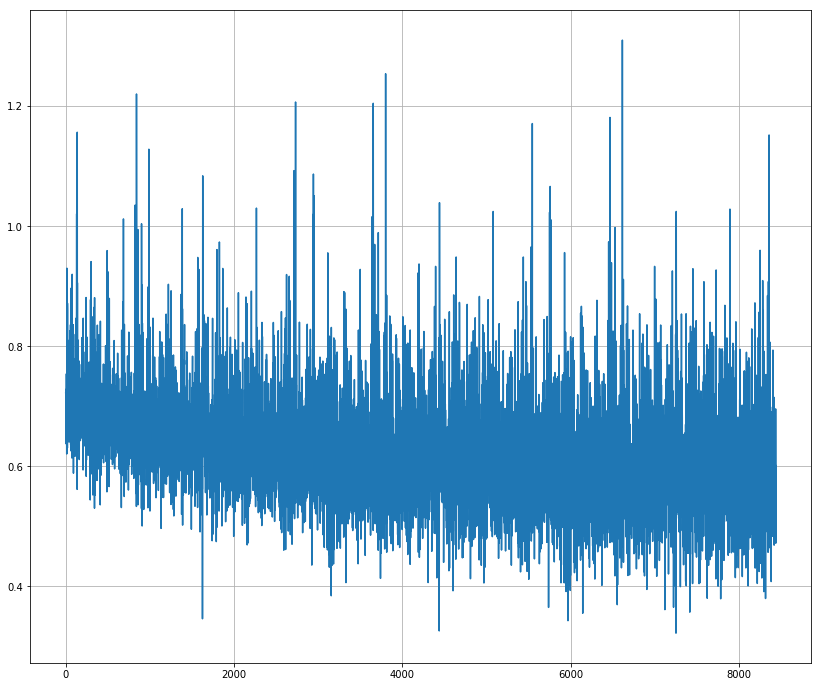

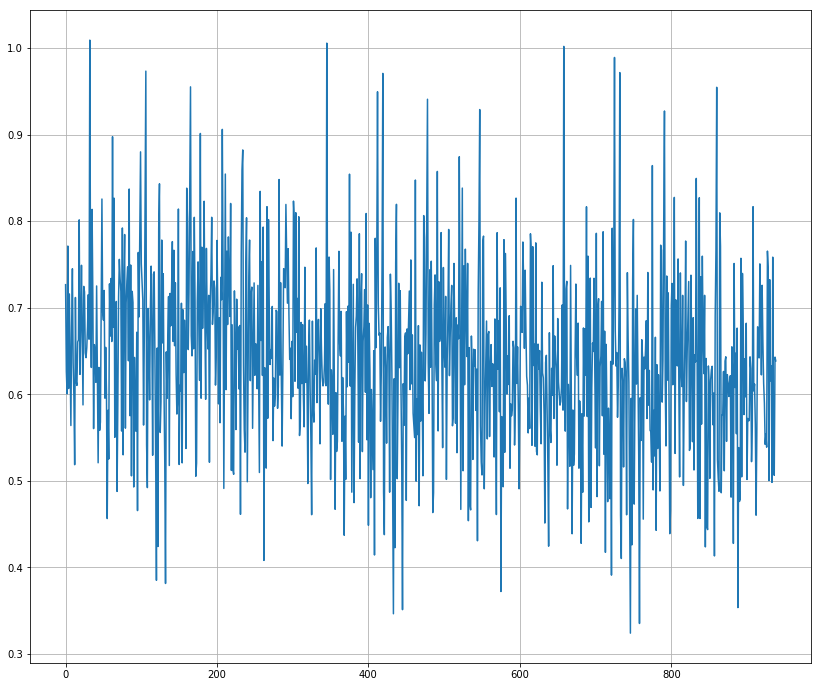

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['loss'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['loss'])
plt.grid()

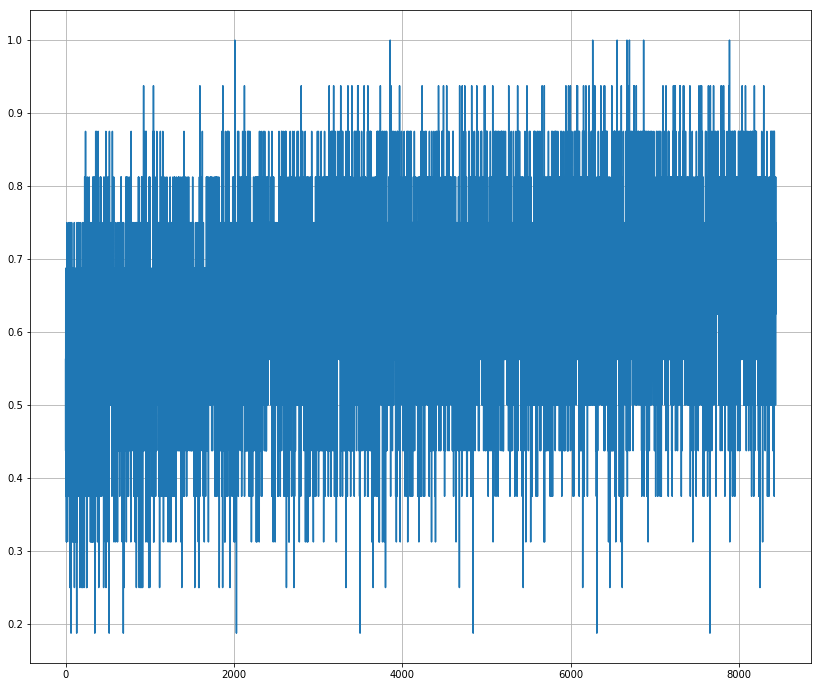

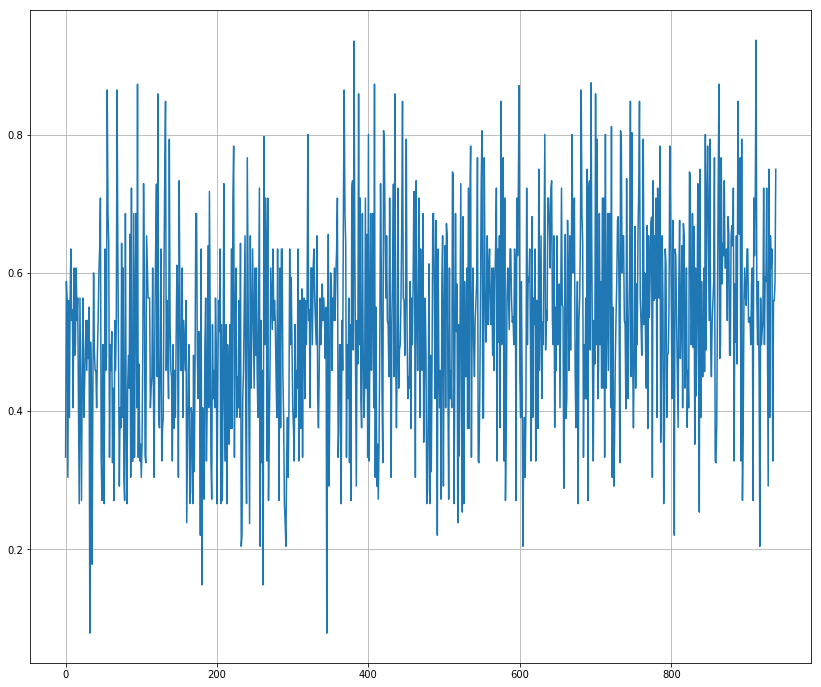

In [29]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['f1'])
plt.grid()